In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import k_means
from helpers import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
def segment_table(path):
    reduction_factor = 30 #30
    table_im_big = cv2.imread(path)
    target_size = (int(table_im_big.shape[1]/reduction_factor),
                   int(table_im_big.shape[0]/reduction_factor))
    table_im = cv2.resize(table_im_big,target_size)
    
    gray_sobel = cv2.cvtColor(sobel_filter(table_im,balance=1), cv2.COLOR_BGR2GRAY)
    log = LoG(gray_sobel,sigma=1,tr=20)

    ### Detect center
    kernel = np.ones((7,7))
    inverse_log = -log + 1
    start_mask = cv2.morphologyEx(inverse_log, cv2.MORPH_OPEN, kernel)
    x_center, y_center = start_mask.shape[0]/2,start_mask.shape[1]/2
    start_indices = zip(np.where(start_mask == 1)[0],np.where(start_mask == 1)[1])
    start = sorted(start_indices,key=lambda l: np.power((l[0]-x_center,l[1]-y_center),2).sum())[0]

    ### Segment table
    kernel = np.ones((2,2))
    inverse_log = cv2.morphologyEx(inverse_log, cv2.MORPH_OPEN, kernel)
    segmentation = np.zeros(inverse_log.shape,dtype=np.uint8)
    for i in iterative_grow(inverse_log,start[0],start[1],0.5):
        segmentation[i[0],i[1]] = 255
    corners = retrieve_corners_opt(segmentation)
    table_segmentation = extract_table(table_im_big,corners,reduction_factor)

    return table_segmentation

In [78]:
table_segmentation = segment_table("data/image_setup/chips.jpg")

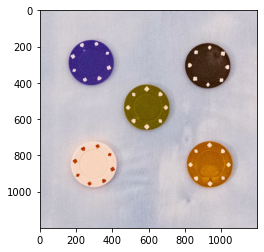

In [79]:
chips = table_segmentation[1300:2500,1100:2300]

plt.imshow(chips)
plt.show()

In [80]:
import cv2 as cv
from skimage.color import rgb2gray

def find_chips(chips, r_min=20, r_max=100):
    all_chips = chips.copy() 
    
    gray = cv.cvtColor(all_chips, cv.COLOR_BGR2GRAY)
    gray = cv.medianBlur(gray, 5)
    circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, r_min, param1=80, param2=40, minRadius=r_min, maxRadius=r_max)
    
    masks = []
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            one_chip = chips.copy()
            center = (i[0], i[1])
            radius = i[2]
            cv.circle(all_chips, center, radius, (0, 0, 0), thickness=-1)
            cv.circle(one_chip, center, radius, (0, 0, 0), thickness=-1)
            gray_chip = rgb2gray(one_chip)
            mask = (gray_chip < 0.0001).astype(int)
            masks.append(mask)

    gray2 = rgb2gray(all_chips)
    big_mask = (gray2 < 0.0001)
    
    return big_mask, masks

In [81]:
big_mask, masks = find_chips(chips, r_min=70, r_max=130)

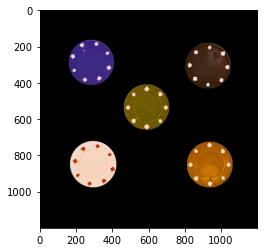

In [82]:
chips2 = chips.copy()
chips2[big_mask==0] = 0

plt.imshow(chips2, cmap='gray')
plt.show()

In [83]:
from sklearn import cluster

g = cluster.KMeans(n_clusters=5).fit(chips[(big_mask == 1)])

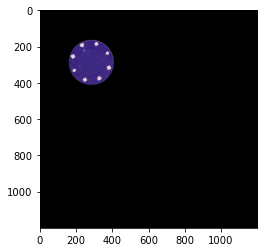

0


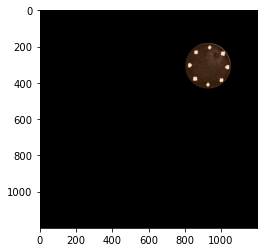

3


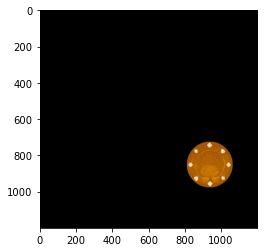

4


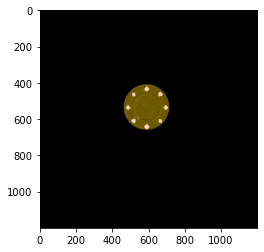

2


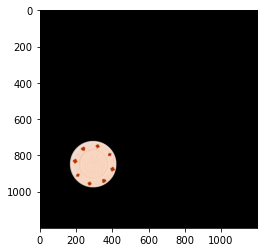

1


In [84]:
for msk in masks:
    pred = g.predict(chips[msk == 1])
    chips3 = chips.copy()
    chips3[msk == 0] = 0
    plt.imshow(chips3)
    plt.show()
    labels = np.array([(pred==0).sum(), (pred==1).sum(), (pred==2).sum(), (pred==3).sum(), (pred==4).sum()])
    print(np.argmax(labels))

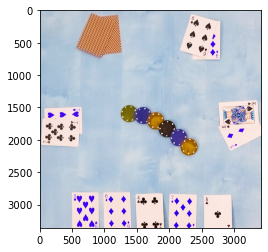

In [85]:
table_segmentation = segment_table("data/train/train_09.jpg")

plt.imshow(table_segmentation)
plt.show()

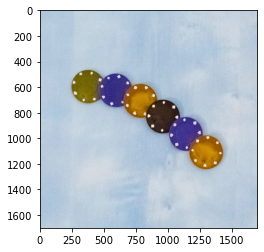

In [86]:
chips = table_segmentation[1000:2700,1000:2700]

plt.imshow(chips)
plt.show()

In [87]:
big_mask, masks = find_chips(chips, r_min=70, r_max=150)

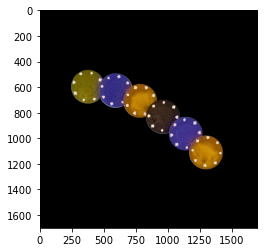

In [88]:
chips2 = chips.copy()
chips2[big_mask==0] = 0

plt.imshow(chips2, cmap='gray')
plt.show()

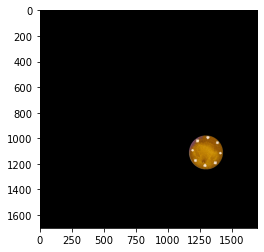

577
3451
11548
387
38730




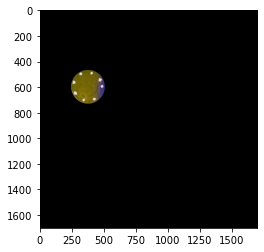

5101
3866
36945
2630
5343




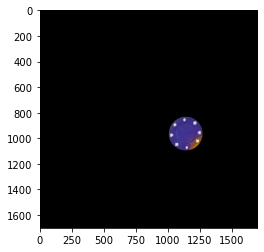

45885
3848
1739
658
1755




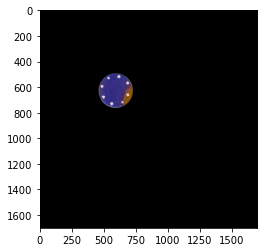

46147
3708
3459
920
2167




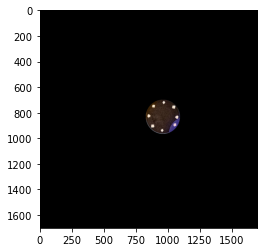

4632
3567
870
46405
83




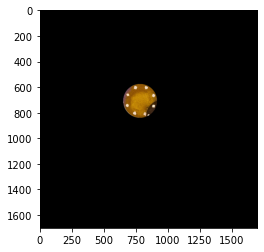

473
3907
13950
4712
31651


[4, 2, 0, 0, 3, 4]


In [89]:
labels = []

for msk in masks:
    pred = g.predict(chips[msk == 1])
    labels.append(np.argmax(np.array([(pred==0).sum(), (pred==1).sum(), (pred==2).sum(), (pred==3).sum(), (pred==4).sum()])))
    chips3 = chips.copy()
    chips3[msk == 0] = 0
    plt.imshow(chips3)
    plt.show()
    print((pred==0).sum())
    print((pred==1).sum())
    print((pred==2).sum())
    print((pred==3).sum())
    print((pred==4).sum())
    print('\n')

print(labels)